In [45]:
import numpy as np
import pandas as pd
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VSIA
import cufflinks as cf
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [47]:
%matplotlib inline
init_notebook_mode(connected=True)
cf.go_offline()
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [49]:
df = pd.read_csv("amazon.csv")
df = df.sort_values("wilson_lower_bound", ascending=False)

In [51]:
def missing_values_analysis(df):
    na_columns_ = [col for col in df.columns if df[col].isnull().sum() > 0]
    n_miss = df[na_columns_].isnull().sum().sort_values(ascending=True)
    ratio_ = (df[na_columns_].isnull().sum() / df.shape[0] * 100).sort_values(ascending=True)
    missing_df = pd.concat([n_miss, np.round(ratio_, 2)], axis=1, keys=['Missing Values', 'Ratio'])
    return missing_df

def check_dataframe(df, head=5, tail=5):
    print("Shape".center(82, '~'))
    print("Rows: {}".format(df.shape[0]))
    print("Columns: {}".format(df.shape[1]))
    print("Types".center(82, '~'))
    print(df.dtypes)
    print("".center(82, '~'))
    print(missing_values_analysis(df))
    print("Duplicate values".center(82, '~'))
    print(df.duplicated().sum())
    print("Quantiles".center(82, '~'))
    df_numeric = df.select_dtypes(include=[np.number])
    print(df_numeric.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_dataframe(df)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Shape~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Rows: 4915
Columns: 12
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Types~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Unnamed: 0                int64
reviewerName             object
overall                   int64
reviewText               object
reviewTime               object
day_diff                  int64
helpful_yes               int64
helpful_no                int64
total_vote                int64
score_pos_neg_diff        int64
score_average_rating    float64
wilson_lower_bound      float64
dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              Missing Values  Ratio
reviewerName               1   0.02
reviewText                 1   0.02
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Duplicate values~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Quantiles~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                       0.00   0.05    0.50         0.9

In [55]:
def check_class(dataframe):
    nunique_df = pd.DataFrame({'Variable': dataframe.columns, 'classes': [dataframe[i].nunique() for i in dataframe.columns]})
    return nunique_df.sort_values('classes', ascending=False).reset_index(drop=True)

check_class(df)

,Variable,classes
0,Unnamed: 0,4915
1,reviewText,4912
2,reviewerName,4594
3,reviewTime,690
4,day_diff,690
5,wilson_lower_bound,40
6,score_average_rating,28
7,score_pos_neg_diff,27
8,total_vote,26
9,helpful_yes,23


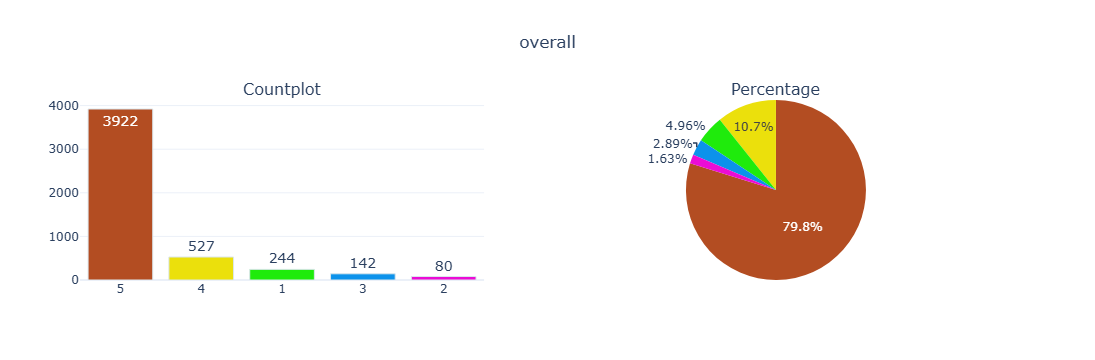

In [57]:
constraints = ['#B34D22','#EBE00C','#1FEB0C','#0C92EB','#EB0CD5']
def variable_summary(df, column_name):
    fig = make_subplots(rows=1, cols=2, subplot_titles=('Countplot','Percentage'), specs=[[{"type":"xy"},{'type':'domain'}]])
    fig.add_trace(go.Bar(
        y=df[column_name].value_counts().values.tolist(),
        x=[str(i) for i in df[column_name].value_counts().index],
        text=df[column_name].value_counts().values.tolist(),
        textfont=dict(size=14),
        name=column_name,
        textposition='auto',
        showlegend=False,
        marker=dict(color=constraints, line=dict(color='#DBE6EC', width=1))
    ), row=1, col=1)

    fig.add_trace(go.Pie(
        labels=df[column_name].value_counts().keys(),
        values=df[column_name].value_counts().values,
        textposition='auto',
        showlegend=False,
        name=column_name,
        marker=dict(colors=constraints)
    ), row=1, col=2)

    fig.update_layout(title={'text': column_name, 'y': 0.9, 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top'}, template='plotly_white')
    iplot(fig)

variable_summary(df, 'overall')

In [61]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', str(text))
    return text.lower()

df["reviewText"] = df["reviewText"].apply(clean_text)

In [69]:
analyzer = VSIA()

def get_sentiment(text):
    score = analyzer.polarity_scores(text)
    if score['neg'] > score['pos']:
        return "Negative"
    elif score['pos'] > score['neg']:
        return "Positive"
    else:
        return "Neutral"

df['sentiment'] = df['reviewText'].apply(get_sentiment)


In [71]:
df[df['sentiment'] == 'Positive'].sort_values("wilson_lower_bound", ascending=False).head(5)

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound,sentiment
2031,2031,"Hyoun Kim ""Faluzure""",5,update so my lovely wife bought me a samsun...,05-01-2013,702,1952,68,2020,1884,0.966337,0.957544,Positive
3449,3449,NLee the Engineer,5,i have tested dozens of sdhc and microsdhc car...,26-09-2012,803,1428,77,1505,1351,0.948837,0.936519,Positive
4212,4212,SkincareCEO,1,note please read the last update scroll to th...,08-05-2013,579,1568,126,1694,1442,0.925620,0.912139,Positive
317,317,"Amazon Customer ""Kelly""",1,if your card gets hot enough to be painful it ...,09-02-2012,1033,422,73,495,349,0.852525,0.818577,Positive
4672,4672,Twister,5,sandisk announcement of the first gb micro sd ...,03-07-2014,158,45,4,49,41,0.918367,0.808109,Positive


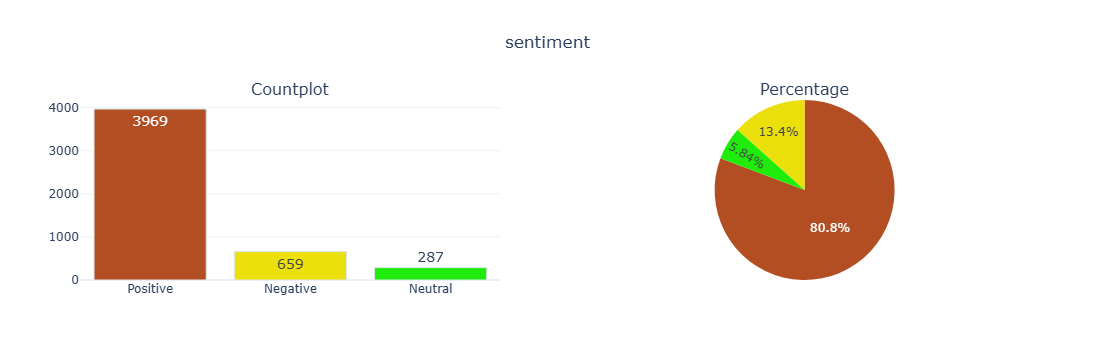

In [73]:
variable_summary(df, 'sentiment')

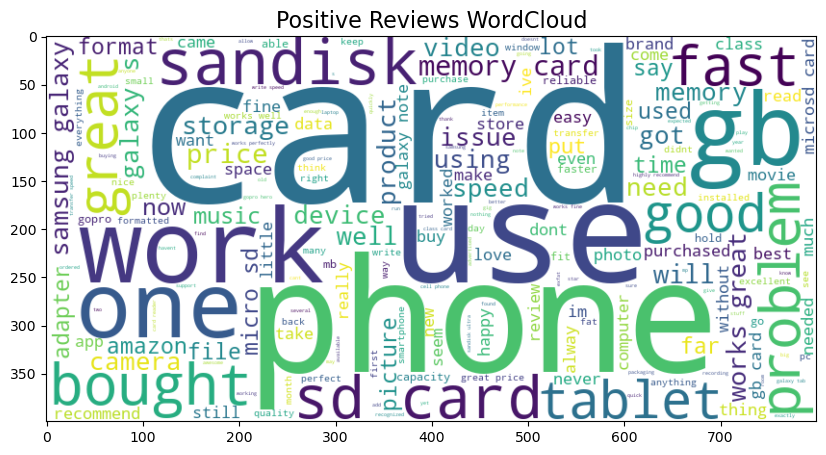

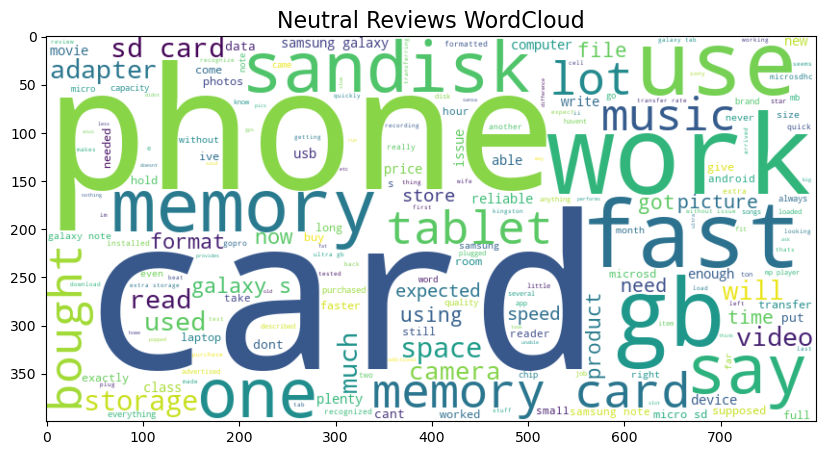

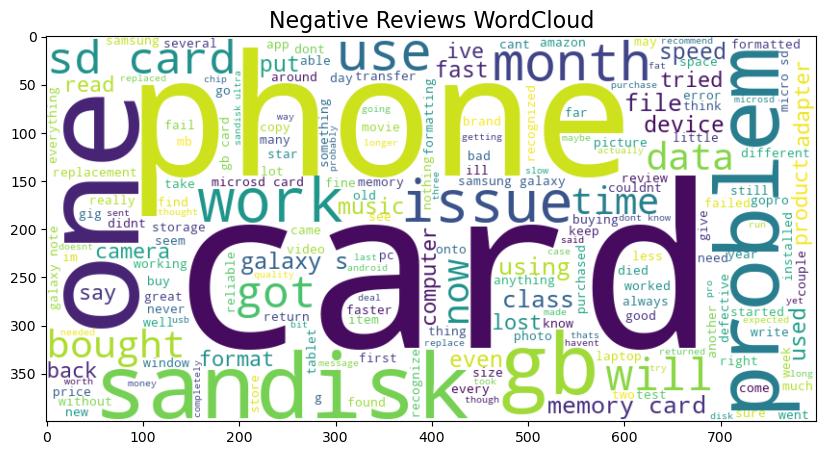

In [81]:
for sentiment in ['Positive', 'Neutral', 'Negative']:
    text = ' '.join(df[df['sentiment'] == sentiment]['reviewText'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('on')
    plt.title(f'{sentiment} Reviews WordCloud', fontsize=16)
    plt.show()


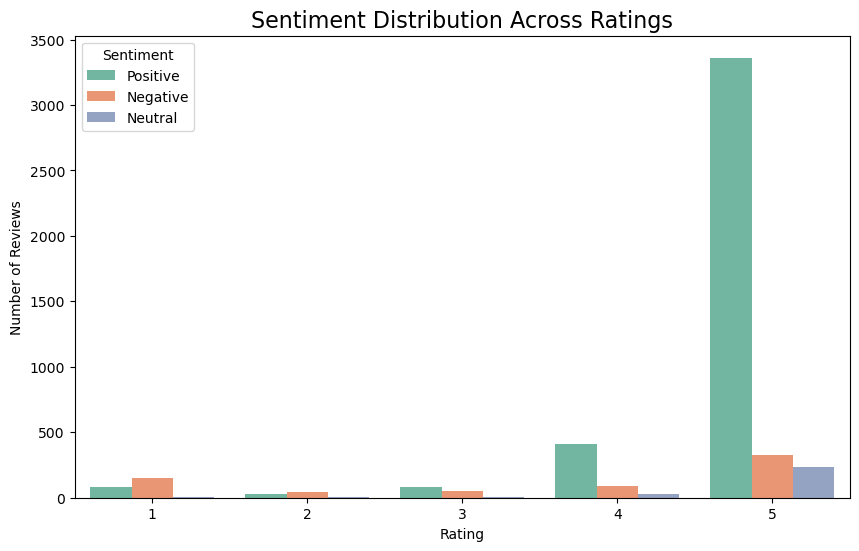

In [79]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='overall', hue='sentiment', palette='Set2')
plt.title('Sentiment Distribution Across Ratings', fontsize=16)
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.legend(title='Sentiment')
plt.show()